# Image classification

## Import libraries

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Define some parameters for the loader:

In [108]:
batch_size = 32
img_height = 64
img_width = 64
num_classes = 2

## Split Dataset (80% Training, 20% Validating)

In [109]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './Training',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3199 files belonging to 2 classes.
Using 2560 files for training.


In [110]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './Training',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3199 files belonging to 2 classes.
Using 639 files for validation.


## Show class name

In [137]:
class_names = train_ds.class_names
print(class_names)

AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [160]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [161]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [162]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

## Data augmentation

In [163]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Build model

In [164]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')

])

## Compile and train the model

In [165]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [166]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   (None, 64, 64, 3)         0         
_________________________________________________________________
rescaling_17 (Rescaling)     (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 64)      

In [167]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
80/80 [==============================] - 10s 101ms/step - loss: 0.3561 - accuracy: 0.8480 - val_loss: 0.2438 - val_accuracy: 0.9014
Epoch 2/25
80/80 [==============================] - 7s 90ms/step - loss: 0.2346 - accuracy: 0.9117 - val_loss: 0.1744 - val_accuracy: 0.9327
Epoch 3/25
80/80 [==============================] - 7s 92ms/step - loss: 0.2108 - accuracy: 0.9191 - val_loss: 0.1819 - val_accuracy: 0.9437
Epoch 4/25
80/80 [==============================] - 7s 92ms/step - loss: 0.1920 - accuracy: 0.9223 - val_loss: 0.1726 - val_accuracy: 0.9390
Epoch 5/25
80/80 [==============================] - 7s 91ms/step - loss: 0.1798 - accuracy: 0.9363 - val_loss: 0.2487 - val_accuracy: 0.9171
Epoch 6/25
80/80 [==============================] - 7s 93ms/step - loss: 0.1718 - accuracy: 0.9375 - val_loss: 0.1713 - val_accuracy: 0.9468
Epoch 7/25
80/80 [==============================] - 7s 90ms/step - loss: 0.1475 - accuracy: 0.9449 - val_loss: 0.1585 - val_accuracy: 0.9484
Epoch 8/25


## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

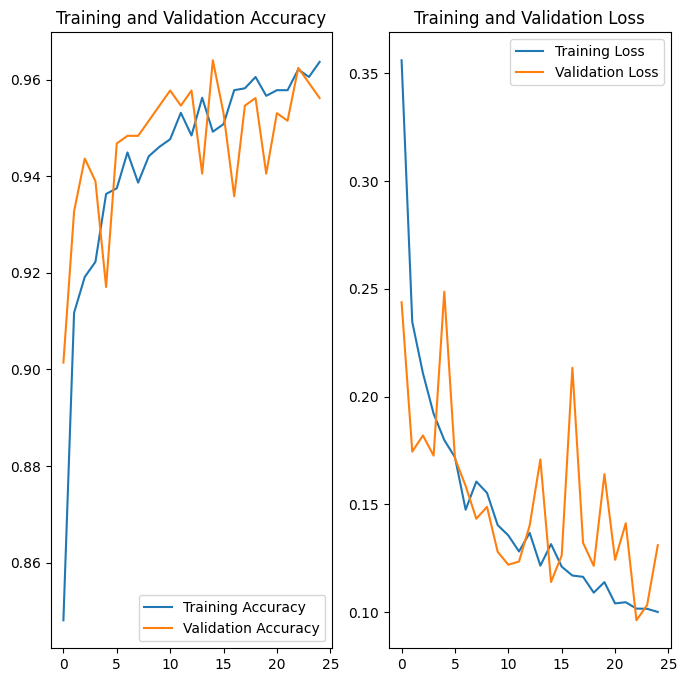

In [168]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

papaya 4.png : Mismatch
papaya 7.png : Mismatch
papaya 11.png : Mismatch
papaya 16.png : Mismatch
papaya 17.png : Mismatch
papaya 18.png : Mismatch
papaya 19.png : Mismatch
papaya 21.png : Mismatch
papaya 25.png : Mismatch
papaya 26.png : Mismatch
papaya 34.png : Mismatch
papaya 35.png : Mismatch
papaya 38.png : Mismatch
papaya 40.png : Mismatch
papaya 45.png : Mismatch
papaya 50.png : Mismatch
papaya 51.png : Mismatch
papaya 52.png : Mismatch
papaya 53.png : Mismatch
papaya 54.png : Mismatch
papaya 58.png : Mismatch
papaya 60.png : Mismatch
papaya 62.png : Mismatch
papaya 64.png : Mismatch
papaya 76.png : Mismatch
papaya 79.png : Mismatch
papaya 81.png : Mismatch
papaya 83.png : Mismatch
papaya 84.png : Mismatch
papaya 86.png : Mismatch
Not papaya 78.png : Mismatch
Not papaya 95.png : Mismatch
Not papaya 135.png : Mismatch
Not papaya 170.png : Mismatch
Not papaya 221.png : Mismatch
35
Efficiency 0.8982558139534884


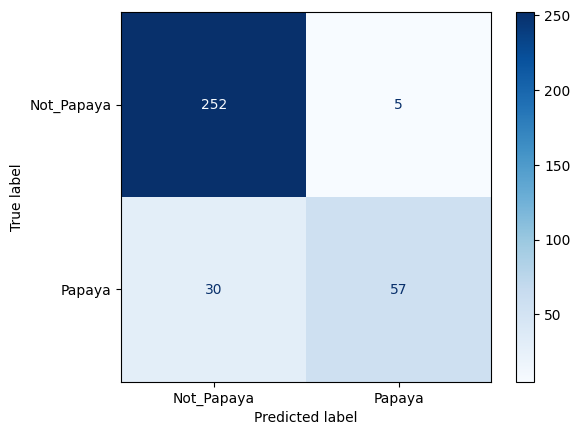

In [171]:
# 0 = not papaya
# 1 = papaya
model = keras.models.load_model("firstModel_binary.h5")
papaya_results=[]
err = 0
for i in range(1,88):
    img = keras.preprocessing.image.load_img(
        f'Testing/Papaya {i}.png', target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if(predictions[0]<0.5):
        print(f'papaya {i}.png : Mismatch')
        err= err+1
        
#     print(f"{i}: {class_names[np.argmax(score)]}")
    papaya_results.append(np.round(predictions[0]))
    
# print(papaya_results)
#     print(
#         "{}: {} with a {:.2f} percent confidence."
#         .format(i,class_names[np.argmax(score)], 100 * np.max(score))
#     )

not_papaya_results=[]
for i in range(1,258):
    img = keras.preprocessing.image.load_img(
        f'Testing/Not Papaya/not_papaya ({i}).jpg', target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    if(predictions[0]>=0.5):
        print(f'Not papaya {i}.png : Mismatch')
        err= err+1
    not_papaya_results.append(np.round(predictions[0]))
#     not_papaya_results.append(class_names[np.argmax(score)])
#     print(
#         "{}: {} with a {:.2f} percent confidence."
#         .format(i,class_names[np.argmax(score)], 100 * np.max(score))
#     )

# print(not_papaya_results)
print(err)
print(f'Efficiency {((257+87)-err)/(257+87)}')

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
test_result = [1]*87+[0]*257
y_pred = papaya_results+not_papaya_results
cm = confusion_matrix(test_result, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()


['Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Not_Papaya', 'Papaya', 'Papaya', 'Papaya', 'Not_Papaya', 'Papaya', 'Papaya', 'Papaya', 'Not_Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Not_Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Not_Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Papaya', 'Not_Papaya', 'Papaya', 'Papaya', 'Not_Papaya', 'Papaya', 'Papaya', 'Papaya', 'Not_Papaya', 'Papaya', 'Papaya', 'Not_Papaya', 'Papaya']
19
Efficiency 0.9447674418604651


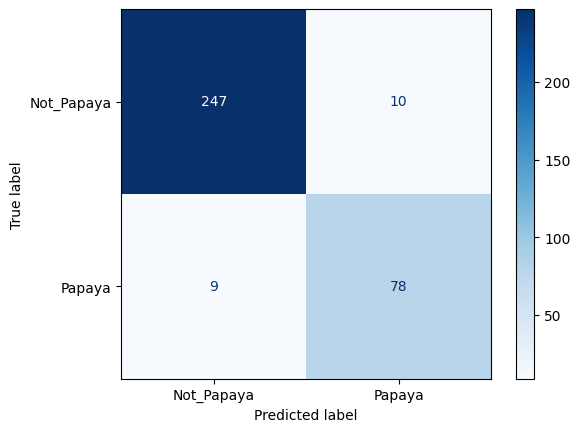

In [133]:
# 0 = not papaya
# 1 = papaya
recon_model = keras.models.load_model("secondModel_Sparse.h5")
papaya_results=[]
err = 0
for i in range(1,88):
    img = keras.preprocessing.image.load_img(
        f'Testing/Papaya {i}.png', target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = recon_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    papaya_results.append(class_names[np.argmax(score)])
    
print(papaya_results)


not_papaya_results=[]
for i in range(1,258):
    img = keras.preprocessing.image.load_img(
        f'Testing/Not Papaya/not_papaya ({i}).jpg', target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = recon_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    not_papaya_results.append(class_names[np.argmax(score)])
#     print(
#         "{}: {} with a {:.2f} percent confidence."
#         .format(i,class_names[np.argmax(score)], 100 * np.max(score))
#     )


err = 0
for i in papaya_results:
    if i=='Not_Papaya':
        err+=1
for i in not_papaya_results:
    if i=='Papaya':
        err+=1
print(err)
print(f'Efficiency {((257+87)-err)/(257+87)}')

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
test_result = ['Papaya']*87+['Not_Papaya']*257
y_pred = papaya_results+not_papaya_results
cm = confusion_matrix(test_result, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [92]:

# err = 0
# for i in papaya_results:
#     if i=='Not_Papaya':
#         err+=1
# for i in not_papaya_results:
#     if i=='Papaya':
#         err+=1
# print(err)
# print((257-err)/257)

In [169]:
# model.save("isPapaya_round11_binary_dense64_epoch_25.h5")